# Introduction

Primary data sources on population are a rare resource in developing countries. When existant, civil registration systems are often patchy. Censuses are rare, and at best happening every 10 years. Meanwhile, in countries with democratic constitutions, elections are held on a more frequent basis. In West Africa, most Constitutions require elections for higher offices to be held every five years. Each time elections are held, voting lists have to be updated, to enlist new voters, and distribute voting identifications. Voters lists should record every person allowed to vote in a country, which can in most situation be equated to the adult population. In this regard, voters list could constitute an interesting data source, providing a regular update on the adult population of a country.

The update of electoral lists is often a conflictual and highly politicized process. In African countries where vote is often overdetermined by geographic and ethnic origins of voters, suspicions of fraud are frequent, with under recording of some categories of voters, and over recording of other categories. Meanwhile, with the development of better techniques for voters identification, and with the development of supervision by civil societies and international agencies, one can hope the completeness and quality of voters lists should be acceptable. Moreover, in order to improve transparence of electoral processes, voters lists are often made available for the public to control and correct.

In Niger, presidential and parlementary elections were held in February 2016. Voters lists were updated during the second half of the year 2015, under the supervision and control of a mission of the Office International de la Francophonie (OIF). Final lists were validated in early January 2016 after being corrected for some incoherencies noted by the supervisory body. Over 7 Million voters were identified in over  25700 voting stations. The Comission Electorale Nationale Independante (CENI) later made these lists fully available on its website.

This work purposes to evaluate how the information made available in voters lists compares with other data sources on Nigerien's population, and how it brings additional knowledge on this population.

# Data

Two main data sources are used in this work :
1. The list of electors, extracted from the CENI website
2. A geolocalized repertoire of all localities and there population, produced during Niger's latest Census

## Voters List

The voters' list was extracted from the [CENI's website](http://www.ceni-niger.org/) using Python's web extraction package _BeautifulSoup_. The extraction first navigated the CENI's website to get the hierarchy of Regions, Departments, Communes and Voting Stations. In a second step, each voting station voting list was read and saved in tabular format in separate files. The lists were then anonymized and compiled in a central file. 

For each voter, the covariates collected were : voting stations, commune, department and region, date of birth, profession. 

Data was obtained for 7,617,613 voters.


## Census / Répertoire National des Localités

The _Répertoire National des Localités_ (RENALOC) was downloaded as a pdf file from the [Institut National de la Statistique (INS) website](http://www.stat-niger.org/). The tables were extracted in bulk from this file using the Tabula Package, and then processed in Python to recompose the geographic structure of the document.

The final data consists in 34507 localities, for which the INS provides the number of inhabitants, by gender, as well as the number of households, and the number of agricultural households. For most of the localities, a GPS coordinate is recorded, as well as the type of locality (neighborhood, village, camp, water well, hamlet).

## Additional Data sources

Administrative boundaries for regions and departements were retrieved from the CENI's website. Boundaries for communes were retrieved from colleagues.

## Data Matching

All data sources (voters list, RENALOC, administrative boundaries) have been matched at commune level. For mapping purposes, some urban areas had to be collapsed at city level.

# Analysis
## Age Structure Imputation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os as os
import numpy as np
import warnings
from IPython.core.display import HTML, display

from ggplot import *
warnings.filterwarnings('ignore')
%matplotlib inline  

voters_data = pd.read_csv('../data/processed/voters_list.csv' , encoding = "ISO-8859-1")
voters_data = voters_data[(voters_data.age >= 18) & (voters_data.NOM_REGION != 'DIASPORA')]
display(HTML("<style>.container { width:100% !important; }</style>"))

### Getting age percentages

In [3]:
def age_distrib(data) :
    data.age[data.age > 100] = 100
    
    out =  np.round(data.age).value_counts() / len(data)
    out = out.reset_index()
    out.columns = ['age' , 'percentage']
    #out.age = out.age.astype(str)
    return out


out = voters_data.groupby('NOM_COMMUNE').apply(age_distrib).reset_index()
out = out.sort(['NOM_COMMUNE', 'age'], ascending=[1, 1])
del out['level_1']

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [4]:
from scipy.interpolate import UnivariateSpline

def spl_age(data):
    out = UnivariateSpline(data['age'] , data['percentage'])
    return out

splines = out.groupby('NOM_COMMUNE').apply(spl_age)

In [5]:
age_extrap = range(0,18)
extrapol_ages = {}
spline_ages = {}
out['spl_age'] = ''
for region in out.NOM_COMMUNE :
    age_range = range(18,101)
    perc_age = splines[region](age_range)
    
    spline_ages[region] = list(perc_age)
    extrapol_ages[region] = list(splines[region](age_extrap))

### Extrapolating non adult age groups

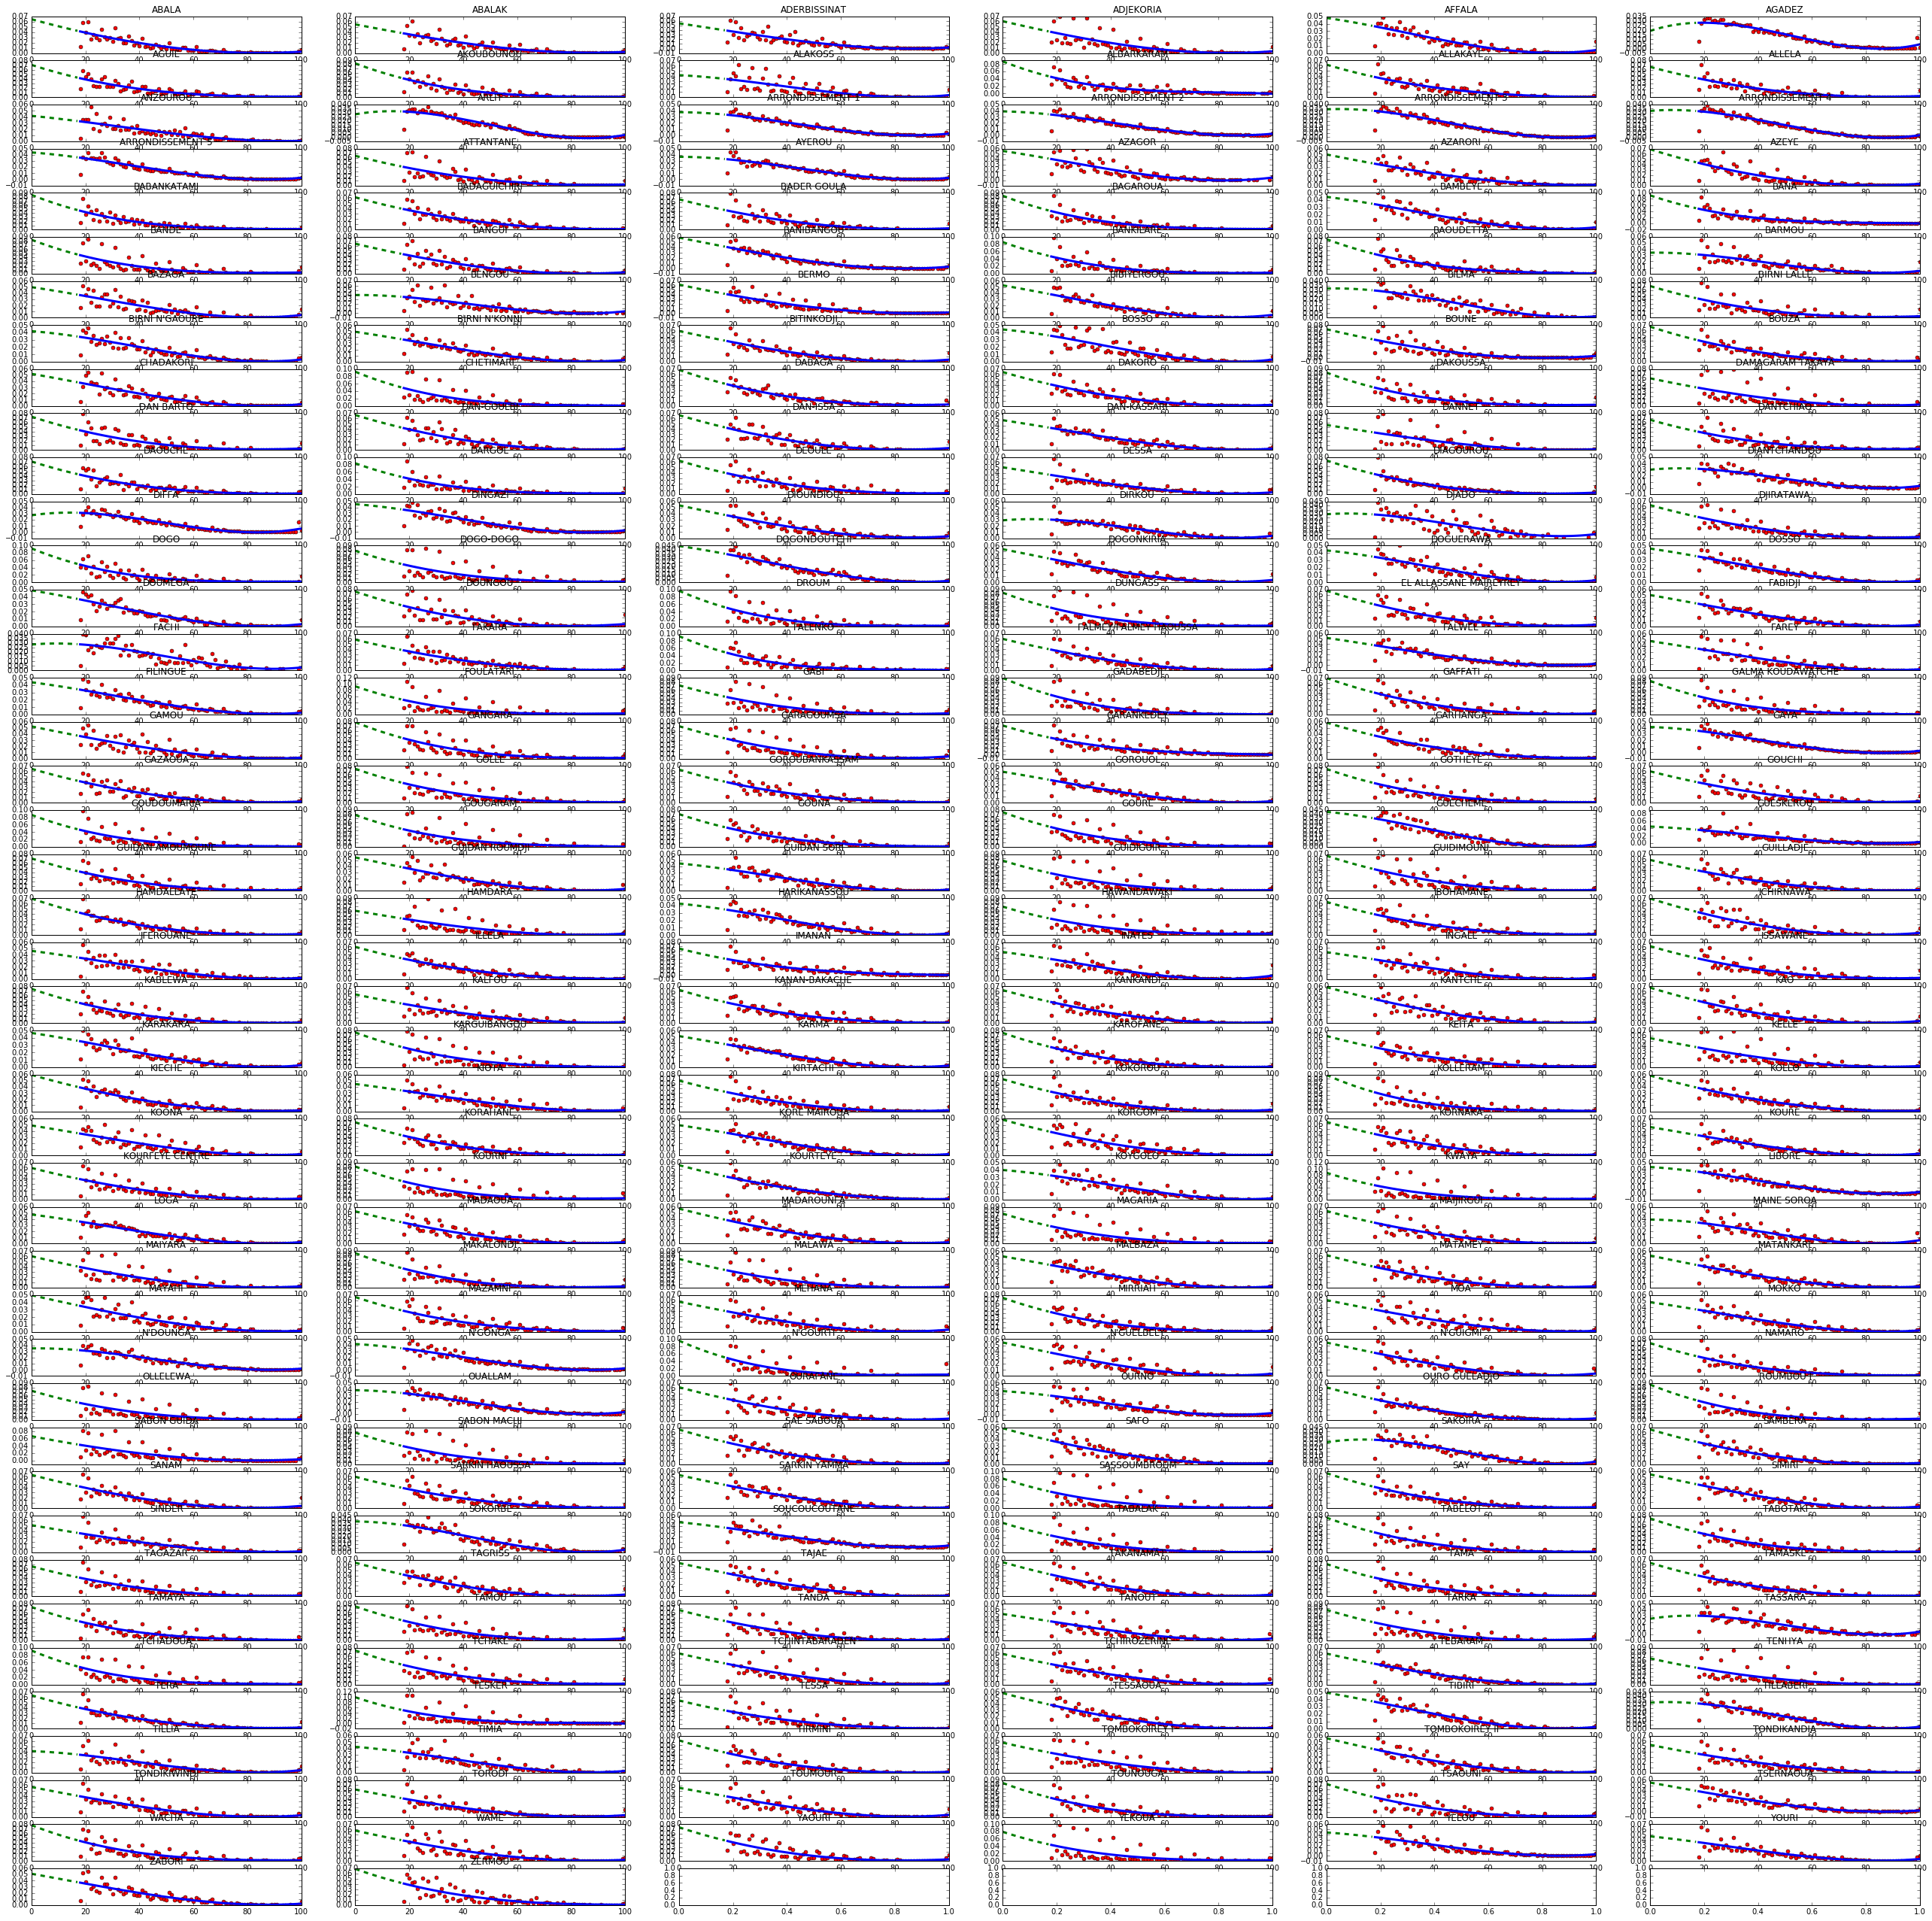

In [6]:
nrow = 43
ncol = 6

f, axarr = plt.subplots(nrow, ncol,figsize=(45,45))
col = row = 0
for region in out.NOM_COMMUNE.unique() :
    axarr[row , col].plot(out[out.NOM_COMMUNE == region].age , out[out.NOM_COMMUNE == region].percentage, 'ro', ms=5 )
    axarr[row , col].plot(list(age_range) , spline_ages[region], 'b', lw=3)
    axarr[row , col].plot(list(age_extrap) , extrapol_ages[region], 'g', lw=3 , ls = 'dashed')
    axarr[row , col].set_title(region)
    col = col + 1
    if col > (ncol - 1) :
        col = 0
        row = row + 1 

## Population Size estimation
### Just summing extrapolated age data

In [7]:
def sum_population(data) :
    return len(data)

pop = voters_data.groupby('NOM_COMMUNE').apply(sum_population)

In [8]:
extrapolated_region = {}
for region in out.NOM_COMMUNE :
    total_pop = sum(np.multiply(extrapol_ages[region] , pop[region])) + pop[region]
    extrapolated_region[region] =  {'pop':total_pop}

In [9]:
census_data = pd.read_csv('../data/processed/commune_collapsed_matched.csv' , encoding = "ISO-8859-1")

In [10]:
def sum_census(data):
    return sum(data.population_census)

census_pop = census_data.groupby('commune').apply(sum_census)

In [11]:
extrapolated_region = pd.DataFrame(extrapolated_region).T.reset_index()
census_pop = census_pop.reset_index()
voters_pop = pop.reset_index()


extrapolated_region.columns = census_pop.columns = voters_pop.columns = ['region' , 'population']

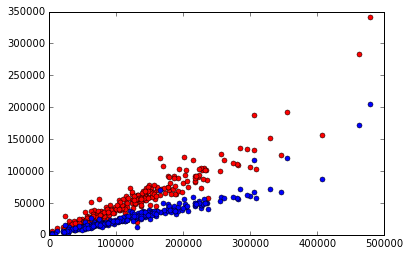

In [12]:
plt.plot(census_pop.population , extrapolated_region.population, 'ro', ms=5 )
plt.plot(census_pop.population , voters_pop.population, 'bo', ms=5 )

In [13]:
## Get relevant sklearn tools
from sklearn import datasets , preprocessing
from sklearn.cross_validation import cross_val_predict
from sklearn import linear_model
from sklearn.feature_extraction import DictVectorizer

## Make data sklearnable
y = np.asarray(census_data.population_census)

x_cat = census_data[['region']].T.to_dict().values()
v = DictVectorizer(sparse=False)
x_cat = v.fit_transform(x_cat)

x_train = np.hstack((census_data[['population_voting_list' , 'mean_age']] , x_cat ))

x_train  = np.asarray(census_data[['population_voting_list' , 'mean_age']]).reshape(len(census_data),2)
## Linear Regression
lr = linear_model.LinearRegression()
predicted_lr = cross_val_predict(lr, x_train  , y, cv=10)

## Ridge Regression
rr = linear_model.Ridge (alpha = .5)
predicted_rr = cross_val_predict(rr, x_train  , y, cv=10)

error = abs(predicted_lr - y)  / y
np.average(error)

0.22004755284647659

In [14]:
data_plot = pd.DataFrame( {'commune' : census_data.commune  , 
                          'value' : y , 'prediction' : predicted_lr , 
                          'error' : error ,
                          'region' : census_data.region})

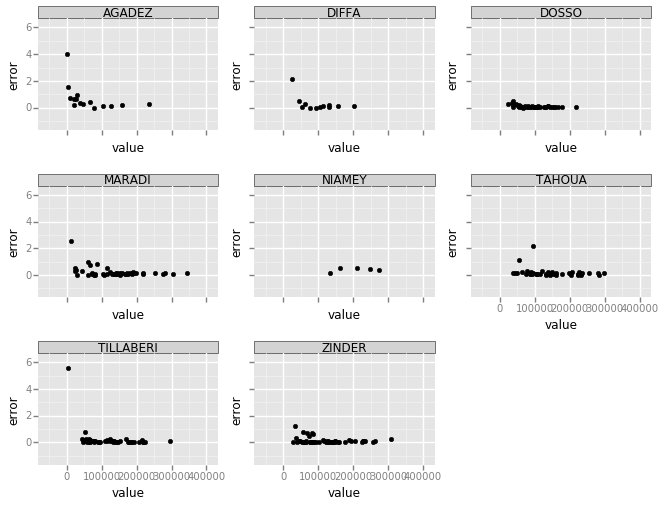

<ggplot: (34847910243)>

In [15]:
ggplot(aes(x = 'value' , y = 'error') , data = data_plot) + geom_point() + \
    facet_wrap('region' , scales = 'fixed')

In [16]:
len(x_train)

266

In [17]:
y = np.asarray(census_pop.population)

#x_cat = census_data[['region']].T.to_dict().values()
#v = DictVectorizer(sparse=False)
#x_cat = v.fit_transform(x_cat)

x_train = np.asarray(extrapolated_region.population).reshape(len(extrapolated_region),1)


## Linear Regression
lr = linear_model.LinearRegression()
predicted_lr = cross_val_predict(lr, x_train  , y, cv=10)

error = abs(predicted_lr - y)  / y

np.average(error)

0.32745353041599634

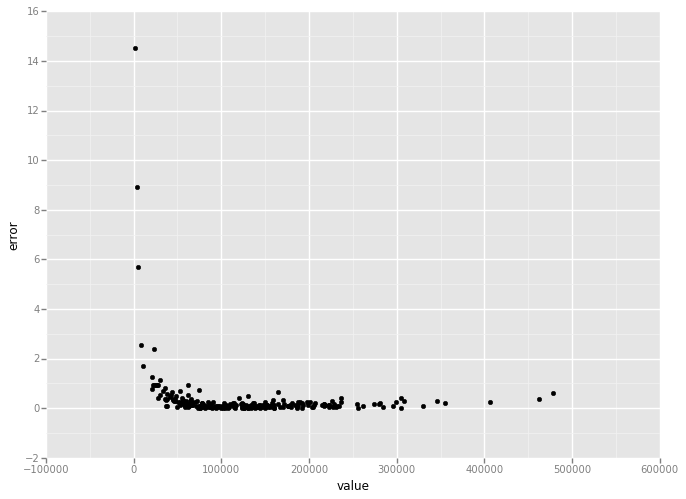

<ggplot: (34840439777)>

In [18]:
data_plot = pd.DataFrame( {'value' : y , 'prediction' : predicted_lr , 
                          'error' : error})
ggplot(aes(x = 'value' , y = 'error') , data = data_plot) + geom_point()

# Results

## Maps

## Age structure reconstitution

## Population Prediction

# Next steps